# Job Scraping and Data Processing

This notebook demonstrates how to scrape job listings from SimplyHired using Selenium, and how to merge and clean the resulting CSV files. The final output is a single merged dataset containing job information like job title, company name, location, estimated salary, job details, and job links. 

## Sections:
1. Scrape job listings for specific roles.
2. Merge scraped data from multiple CSV files.
3. Standardize column names and handle missing data.

## Scrape Job Listings

The `scrape_jobs` function performs web scraping on the SimplyHired website. Given a job title and location, it:
- Constructs the URL.
- Collects job titles, company names, locations, estimated salaries, job details, and job links.
- Handles pagination and error logging.
- Saves the data as a CSV file named based on the job title and location.

**Key Features:**
- Scrapes job listings using Selenium.
- Handles multiple pages and collects job details from each job link.
- Logs errors to a file (`web_scraping_errors.log`) to help with debugging.

In [1]:
import pandas as pd

def scrape_jobs(job_title, location):
    from selenium import webdriver
    from selenium.webdriver.common.by import By
    import time
    from selenium.common.exceptions import NoSuchElementException
    import logging

    # Set up logging to capture errors
    logging.basicConfig(filename='web_scraping_errors.log', level=logging.ERROR)

    # Create a Chrome browser instance
    driver = webdriver.Chrome()

    # Construct the URL
    url = f"https://www.simplyhired.com/search?q={job_title}&l={location}"

    # Initialize data lists
    job_titles, company_names, job_locations, est_salary, job_details, job_hrefs = [], [], [], [], [], []

    total_job_count = 0

    try:
        # Visit the URL
        driver.get(url)

        while True:
            # Extract the total job count from the element
            total_job_element = driver.find_element(By.CSS_SELECTOR, "p.css-gu0het")
            total_job_count = int(total_job_element.text)

            # Find all job title elements and corresponding company name elements on the current page
            job_title_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='searchSerpJobTitle'] a")
            company_name_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='companyName']")
            job_location_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='searchSerpJobLocation']")
            est_salary_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='searchSerpJobSalaryEst']")
            job_href_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='searchSerpJobTitle'] a")

            # Iterate through the job elements to extract job titles, company names, and href links
            for job_title_element, company_name_element, job_location_element, est_salary_element, job_href_element in zip(job_title_elements, company_name_elements, job_location_elements, est_salary_elements, job_href_elements):
                job_titles.append(job_title_element.text)
                company_names.append(company_name_element.text)
                job_locations.append(job_location_element.text)
                est_salary.append(est_salary_element.text)

                # Click on the job href to get details and open in a new window
                job_href = job_href_element.get_attribute("href")
                job_hrefs.append(job_href)  # Store the href link
                driver.execute_script("window.open('', '_blank');")
                driver.switch_to.window(driver.window_handles[1])
                driver.get(job_href)

                try:
                    job_detail_element = driver.find_element(By.CSS_SELECTOR, "[data-testid='viewJobBodyJobFullDescriptionContent']")
                    job_details.append(job_detail_element.text)
                except NoSuchElementException:
                    job_details.append("N/A")

                driver.close()  # Close the job details tab
                driver.switch_to.window(driver.window_handles[0])  # Switch back to the job listing tab

            # Find the next page button
            next_page_button = driver.find_element(By.XPATH, "//a[@aria-label='Next page']")

            # Scroll to the next page button to make it clickable
            driver.execute_script("arguments[0].scrollIntoView();", next_page_button)

            # Click the next page button
            next_page_button.click()

            # Wait for a short period before loading the next page
            time.sleep(5)  # Wait for 5 seconds

            # Break the loop if we have collected data from all pages
            if len(job_titles) >= total_job_count:
                break

    except NoSuchElementException as e:
        # Handle the specific exception (element not found)
        logging.error(f"Element not found error: {str(e)}")
    except Exception as e:
        # Handle other exceptions and log them
        logging.error(f"An error occurred: {str(e)}")

    finally:
        # Close the browser when done
        driver.quit()

    # Create a dictionary to store the data
    data = {
        'Job Title': job_titles,
        'Company Name': company_names,
        'Job Location': job_locations,
        'Estimated Salary': est_salary,
        'Job details': job_details,
        'Job Href': job_hrefs  # Include the href links
    }

    # Check if all lists have the same length
    lengths = set(len(lst) for lst in data.values())
    if len(lengths) == 1:
        # All lists have the same length, create the DataFrame
        df = pd.DataFrame(data)
    else:
        # Lists have different lengths, handle the error
        print("Error: Lists have different lengths")
        df = None  # Set df to None or handle the error as needed

    # Save the data to a CSV file if the DataFrame is not None
    if df is not None:
        file_name = f'{job_title}_{location}_{time.strftime("%Y-%m-%d")}.csv'
        df.to_csv(file_name, index=False)

    # Return the DataFrame (or None)
    return df


## Scraping Data for Different Job Roles

Here we demonstrate scraping job listings for different roles such as Data Engineer, Software Engineer, and Data Scientist. Each search result is saved into a separate CSV file.

For example:
- **Data Engineer** jobs in California.
- **Software Engineer** jobs in California.
- **Data Scientist** jobs in California.
- **Data Analyst** jobs in California.
- **Business Systems Analyst** jobs in California.
- **Software Developer** jobs in California.

Can be done for multiple roles in any location.

We used California as it is the most populous state in the United States with majority of tech roles in it.

In [2]:
data_engineer = scrape_jobs("Data Engineer", "California")
data_engineer
data_engineer.to_csv("data/data_engineer.csv", index=False)

In [3]:
Software_engineer = scrape_jobs("Software Engineer", "California")
Software_engineer
Software_engineer.to_csv("data/software_engineer.csv", index=False)

In [4]:
Data_Scientist = scrape_jobs("Data Scientist", "California")
Data_Scientist
Data_Scientist.to_csv("data/data_scientist.csv", index=False)

In [5]:
Data_Analyst = scrape_jobs("Data Analyst", "California")
Data_Analyst
Data_Analyst.to_csv("data/data_analyst.csv", index=False)

In [6]:
Business_Systems_Analyst = scrape_jobs("Business Systems Analyst", "California")
Business_Systems_Analyst
Business_Systems_Analyst.to_csv("data/business_systems_analyst.csv", index=False)

In [7]:
Software_Developer = scrape_jobs("Software_Developer", "California")
Software_Developer
Software_Developer.to_csv("data/software_developer.csv", index=False)

# Mapping the column names in all the csv files and merge csv files

## Merging CSV Files

After scraping multiple job roles, the data is stored in separate CSV files. In this section, we:
- Load all CSV files from the `data/` folder.
- Standardize the column names to maintain consistency across different datasets.
- Merge all CSV files into a single DataFrame.

**Column Mapping:**
We use a dictionary to map inconsistent column names (like `Job Title`, `Company`, `Location`) to standardized names (`Job_Title`, `Company_Name`, `Job_Location`, etc.).

## Standardize and Merge Data

In this step:
- All columns in the CSV files are renamed according to the `column_name_mapping`.
- The data is concatenated into a single DataFrame, ensuring that all records have a uniform structure.
- The resulting DataFrame contains columns like `Job_Title`, `Company_Name`, `Job_Location`, `Estimated_Salary`, `Job_Details`, and `Hyperlink`.

In [8]:
import os 
# Define the path to the folder containing CSV files
folder_path = 'data/'

# Get a list of all CSV files in the folder
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Define a dictionary to map old column names to new column names
column_name_mapping = {
    'Job Title': 'Job_Title',
    'Company Name': 'Company_Name',
    'Company' : 'Company_Name',
    'Location': 'Job_Location',
    'Job Location': 'Job_Location',
    'Salary': 'Estimated_Salary',
    'Estimated Salary': 'Estimated_Salary',
    'Href': 'Hyperlink',
    'Job Href': 'Hyperlink',
    'Job Description': 'Job_Details',
    'Job details': 'Job_Details'
}

# Read all CSV files into DataFrames and rename columns
dataframes = []

for file_path in file_paths:
    df = pd.read_csv(file_path)
    df.rename(columns=column_name_mapping, inplace=True)
    dataframes.append(df)

# Concatenate the DataFrames row-wise
merged_df = pd.concat(dataframes, ignore_index=True)

# Define the desired column order
desired_columns = [
    'Job_Title',
    'Company_Name',
    'Job_Location',
    'Estimated_Salary',
    'Job_Details',
    'Hyperlink',
]

# Reorder columns to match the desired order
merged_df = merged_df[desired_columns]

# Save the merged DataFrame to a CSV file
merged_df.to_csv('data/merged_file.csv', index=False)


## Final Merged DataFrame

The merged dataset contains all the scraped job listings across different job roles. Below, we display a preview of the first few rows of the combined dataset.

You can save this final DataFrame to a CSV file for further analysis.

In [9]:
merged_df

,Job_Title,Company_Name,Job_Location,Estimated_Salary,Job_Details,Hyperlink
0,Data Scientist,DeBlase Brown Eyerly LLP,"Los Angeles, CA",Estimated: $99.5K - $126K a year,"*Job Summary*\nAs the firm's Data Scientist, y...",https://www.simplyhired.com/job/bZQOCTwB4OhuNP...
1,Data Scientist,"Hunter International, Inc",United States,Estimated: $186K - $235K a year,Data Scientist\nRemote\n\nData Scientist will ...,https://www.simplyhired.com/job/XgK65fY8PvxIAD...
2,Principal Data Science / AI Architect,ASML,"San Diego, CA",Estimated: $164K - $207K a year,Introduction to the job\nASML brings together ...,https://www.simplyhired.com/job/ion4EYmTkDbOVb...
3,Senior Machine Learning Engineer,ASML,"San Diego, CA",Estimated: $146K - $185K a year,Introduction to the job\nThe EUV Source team i...,https://www.simplyhired.com/job/IdSfU7FJXvunKb...
4,Medicine - Artificial Intelligence Faculty,CEDARS-SINAI,"Los Angeles, CA",Estimated: $71.7K - $90.8K a year,The Division of Artificial Intelligence in Med...,https://www.simplyhired.com/job/_t1HoPxcMcxPUC...
...,...,...,...,...,...,...
6143,Application Engineer II - Data Management (Min...,Ansys,"San Diego, CA",Estimated: $116K - $147K a year,Requisition #: 14831\n\nOur Mission: Powering ...,https://www.simplyhired.com/job/KDvCkdU6RSLBMr...
6144,Senior Network Engineer - RRMS Data Center,Rapid Response Monitoring,"Corona, CA",Estimated: $113K - $143K a year,Location\nThis position is 100% in-office and ...,https://www.simplyhired.com/job/CXnvktX5Idn-qe...
6145,Data Platform Engineer,Joyent,"Mountain View, CA",Estimated: $150K - $190K a year,"Mountain View, CA, Hybrid (3 times per week)\n...",https://www.simplyhired.com/job/47Ex9cyS9zJSmA...
6146,Cellular 4G/5G Firmware Data Science & Machine...,Apple,"Sunnyvale, CA",Estimated: $114K - $144K a year,"Summary\n\nPosted: Jul 25, 2024\n\nRole Number...",https://www.simplyhired.com/job/gMY9aLS1SsD1bC...


In [10]:
merged_df['Job_Title'][0]

'Data Scientist'

In [11]:
merged_df.Job_Details.isna().sum()

0

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers

# Load the CSV file
data = pd.read_csv('data/merged_file.csv')  # We're only interested in Job_Title and Job_Details columns
data = data[['Job_Title', 'Job_Details']]   # Preprocess the job details (filling any missing values)
data['Job_Details'] = data['Job_Details'].fillna('')    # TF-IDF Vectorization for job details

data


2024-10-09 21:38:36.053968: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Job_Title,Job_Details
0,Data Scientist,"*Job Summary*\nAs the firm's Data Scientist, y..."
1,Data Scientist,Data Scientist\nRemote\n\nData Scientist will ...
2,Principal Data Science / AI Architect,Introduction to the job\nASML brings together ...
3,Senior Machine Learning Engineer,Introduction to the job\nThe EUV Source team i...
4,Medicine - Artificial Intelligence Faculty,The Division of Artificial Intelligence in Med...
...,...,...
6143,Application Engineer II - Data Management (Min...,Requisition #: 14831\n\nOur Mission: Powering ...
6144,Senior Network Engineer - RRMS Data Center,Location\nThis position is 100% in-office and ...
6145,Data Platform Engineer,"Mountain View, CA, Hybrid (3 times per week)\n..."
6146,Cellular 4G/5G Firmware Data Science & Machine...,"Summary\n\nPosted: Jul 25, 2024\n\nRole Number..."


In [13]:
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(data['Job_Details']).toarray() # We can use the Job_Title as our target label, converting it into a numeric form

# Define the LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Job_Title'])  # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # Define a basic Neural Network model in TensorFlow

# Define the model
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   # Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))  # Predict job titles based on job details

# Evaluate the model
predictions = model.predict(X_test)
predicted_job_titles = label_encoder.inverse_transform(predictions.argmax(axis=1))  # Example: Print one prediction and its corresponding job description
for i in range(5):
    print(f"Predicted Job Title: {predicted_job_titles[i]}")
    print(f"Job Description: {data['Job_Details'].iloc[i]}\n")  # Save the model for later use
model.save('resume_generator_model.h5')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1410 - loss: 5.6108 - val_accuracy: 0.4545 - val_loss: 3.2866
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5046 - loss: 3.0309 - val_accuracy: 0.6447 - val_loss: 2.2411
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6632 - loss: 2.0391 - val_accuracy: 0.7463 - val_loss: 1.6876
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7562 - loss: 1.4642 - val_accuracy: 0.8065 - val_loss: 1.3604
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8128 - loss: 1.0806 - val_accuracy: 0.8488 - val_loss: 1.1268
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8615 - loss: 0.7808 - val_accuracy: 0.8764 - val_loss: 0.9991
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8944 - loss: 0.5680 - val_accuracy: 0.8829 - val_loss: 0.9317
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9224 - loss: 0.4058 - val_accu

## Clustering Analysis
The PCA algorithm is used to reduce the dimensionality of the data, and the elbow method and silhouette score are used to determine the optimal number of clusters.
Our elbow method and silhouette score plots are shown below:

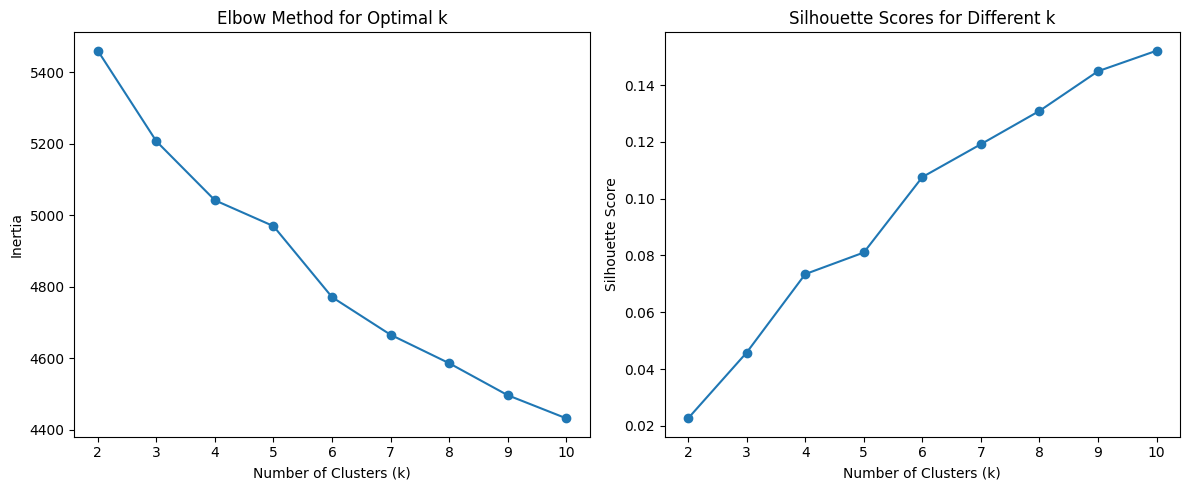

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Determine optimal number of clusters using Elbow Method and Silhouette Score
max_clusters = 10
inertias = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Visualize Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.tight_layout()
plt.show()


In [15]:
# Choose optimal number of clusters based on the plots
optimal_k = 5  # Adjust this value based on your analysis

# Perform K-Means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)

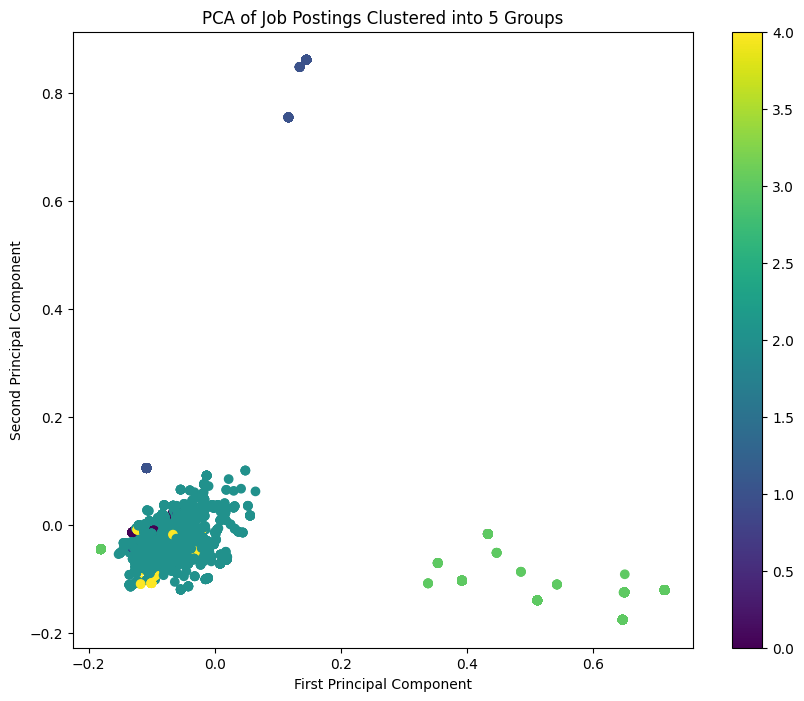


Clustering Analysis Findings:
1. Optimal number of clusters: 5
2. Each cluster represents a group of job postings with similar skills and qualifications.
3. The PCA visualization shows how these clusters are distributed in a 2D space.

Cluster 0:
Number of jobs: 233
Top job titles:
Job_Title
Project Coordinator & Data Analyst    48
Expert IT SAP Functional Analyst      47
SAP ME/MII Developer                  35
Expert Business System Specialist     25
Analyst (Music Royalties) (4002)      25
Name: count, dtype: int64

Most common words:
and         8071
to          3426
the         2885
SAP         2848
of          2648
in          2206
with        1688
business    1442
for         1268
a           1091
Name: count, dtype: int64

Cluster 1:
Number of jobs: 663
Top job titles:
Job_Title
Software Engineer                   249
Sr. Software Developer              168
Landing Page Developer/Designer     108
Software Engineer Manager C++ C#    105
Software Engineer Lead               33
N

In [16]:
# Visualization using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'PCA of Job Postings Clustered into {optimal_k} Groups')
plt.show()

# Documentation and Analysis
print("\nClustering Analysis Findings:")
print(f"1. Optimal number of clusters: {optimal_k}")
print("2. Each cluster represents a group of job postings with similar skills and qualifications.")
print("3. The PCA visualization shows how these clusters are distributed in a 2D space.")

# Analyze clusters
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_jobs = data[cluster_labels == cluster]
    print(f"Number of jobs: {len(cluster_jobs)}")
    print("Top job titles:")
    print(cluster_jobs['Job_Title'].value_counts().head())
    print("\nMost common words:")
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    words = cluster_text.split()
    word_freq = pd.Series(words).value_counts()
    print(word_freq.head(10))

print("\nInsights gained from unsupervised learning:")
print("1. The job market can be segmented into distinct groups based on required skills and qualifications.")
print("2. Some clusters may represent specific job categories or industries.")
print("3. The distribution of job titles within each cluster can reveal trends in job market demand.")
print("4. Common words in each cluster can highlight the key skills and qualifications for different job categories.")
print("5. This clustering can help in tailoring resumes for specific job clusters or identifying emerging job categories.")



## Word Cloud Visualizations
These visualizations highlight keyword frequencies in the resume and job descriptions.
Shows the most common keywords, helping identify focus areas in the resume.
We removed stopwords from the word cloud to improve readability. 

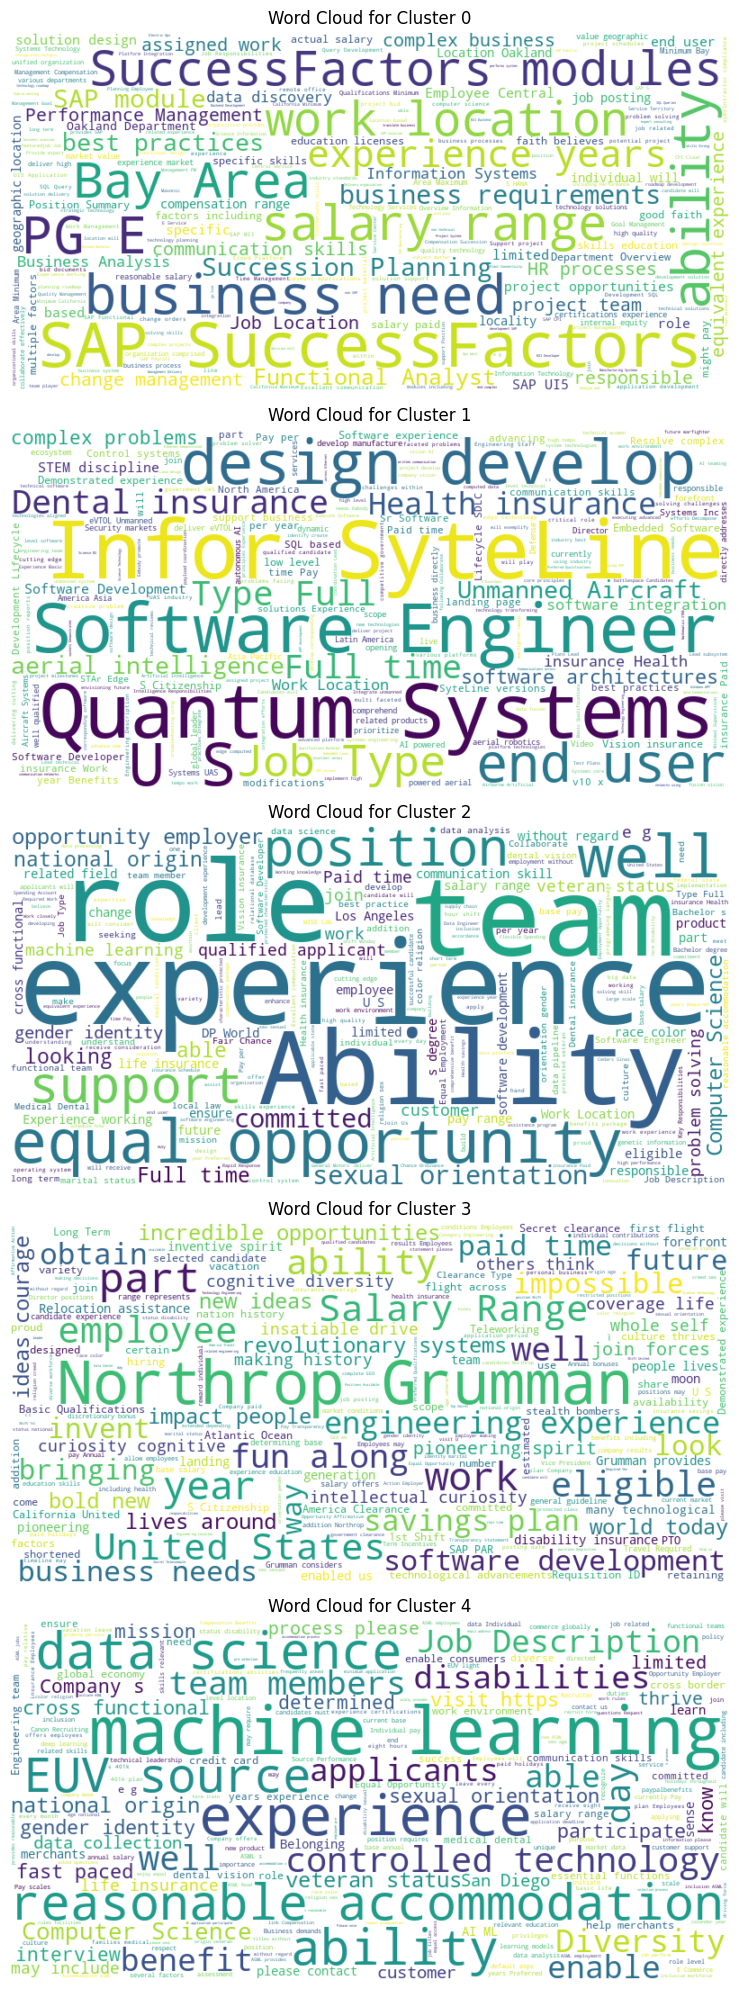

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Word cloud for each cluster
plt.figure(figsize=(20, 4 * optimal_k))
stopwords = set(STOPWORDS)  # Add predefined stop words

for cluster in range(optimal_k):
    cluster_jobs = data[cluster_labels == cluster]
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    
    # Generate the word cloud with stopwords removed
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(cluster_text)
    
    plt.subplot(optimal_k, 1, cluster + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')

plt.tight_layout()
plt.show()


## Bar Plot Visualizations
These visualizations highlight keyword frequencies in the resume and job descriptions.
Compare keyword usage in the resume vs. job descriptions to spot alignment gaps.

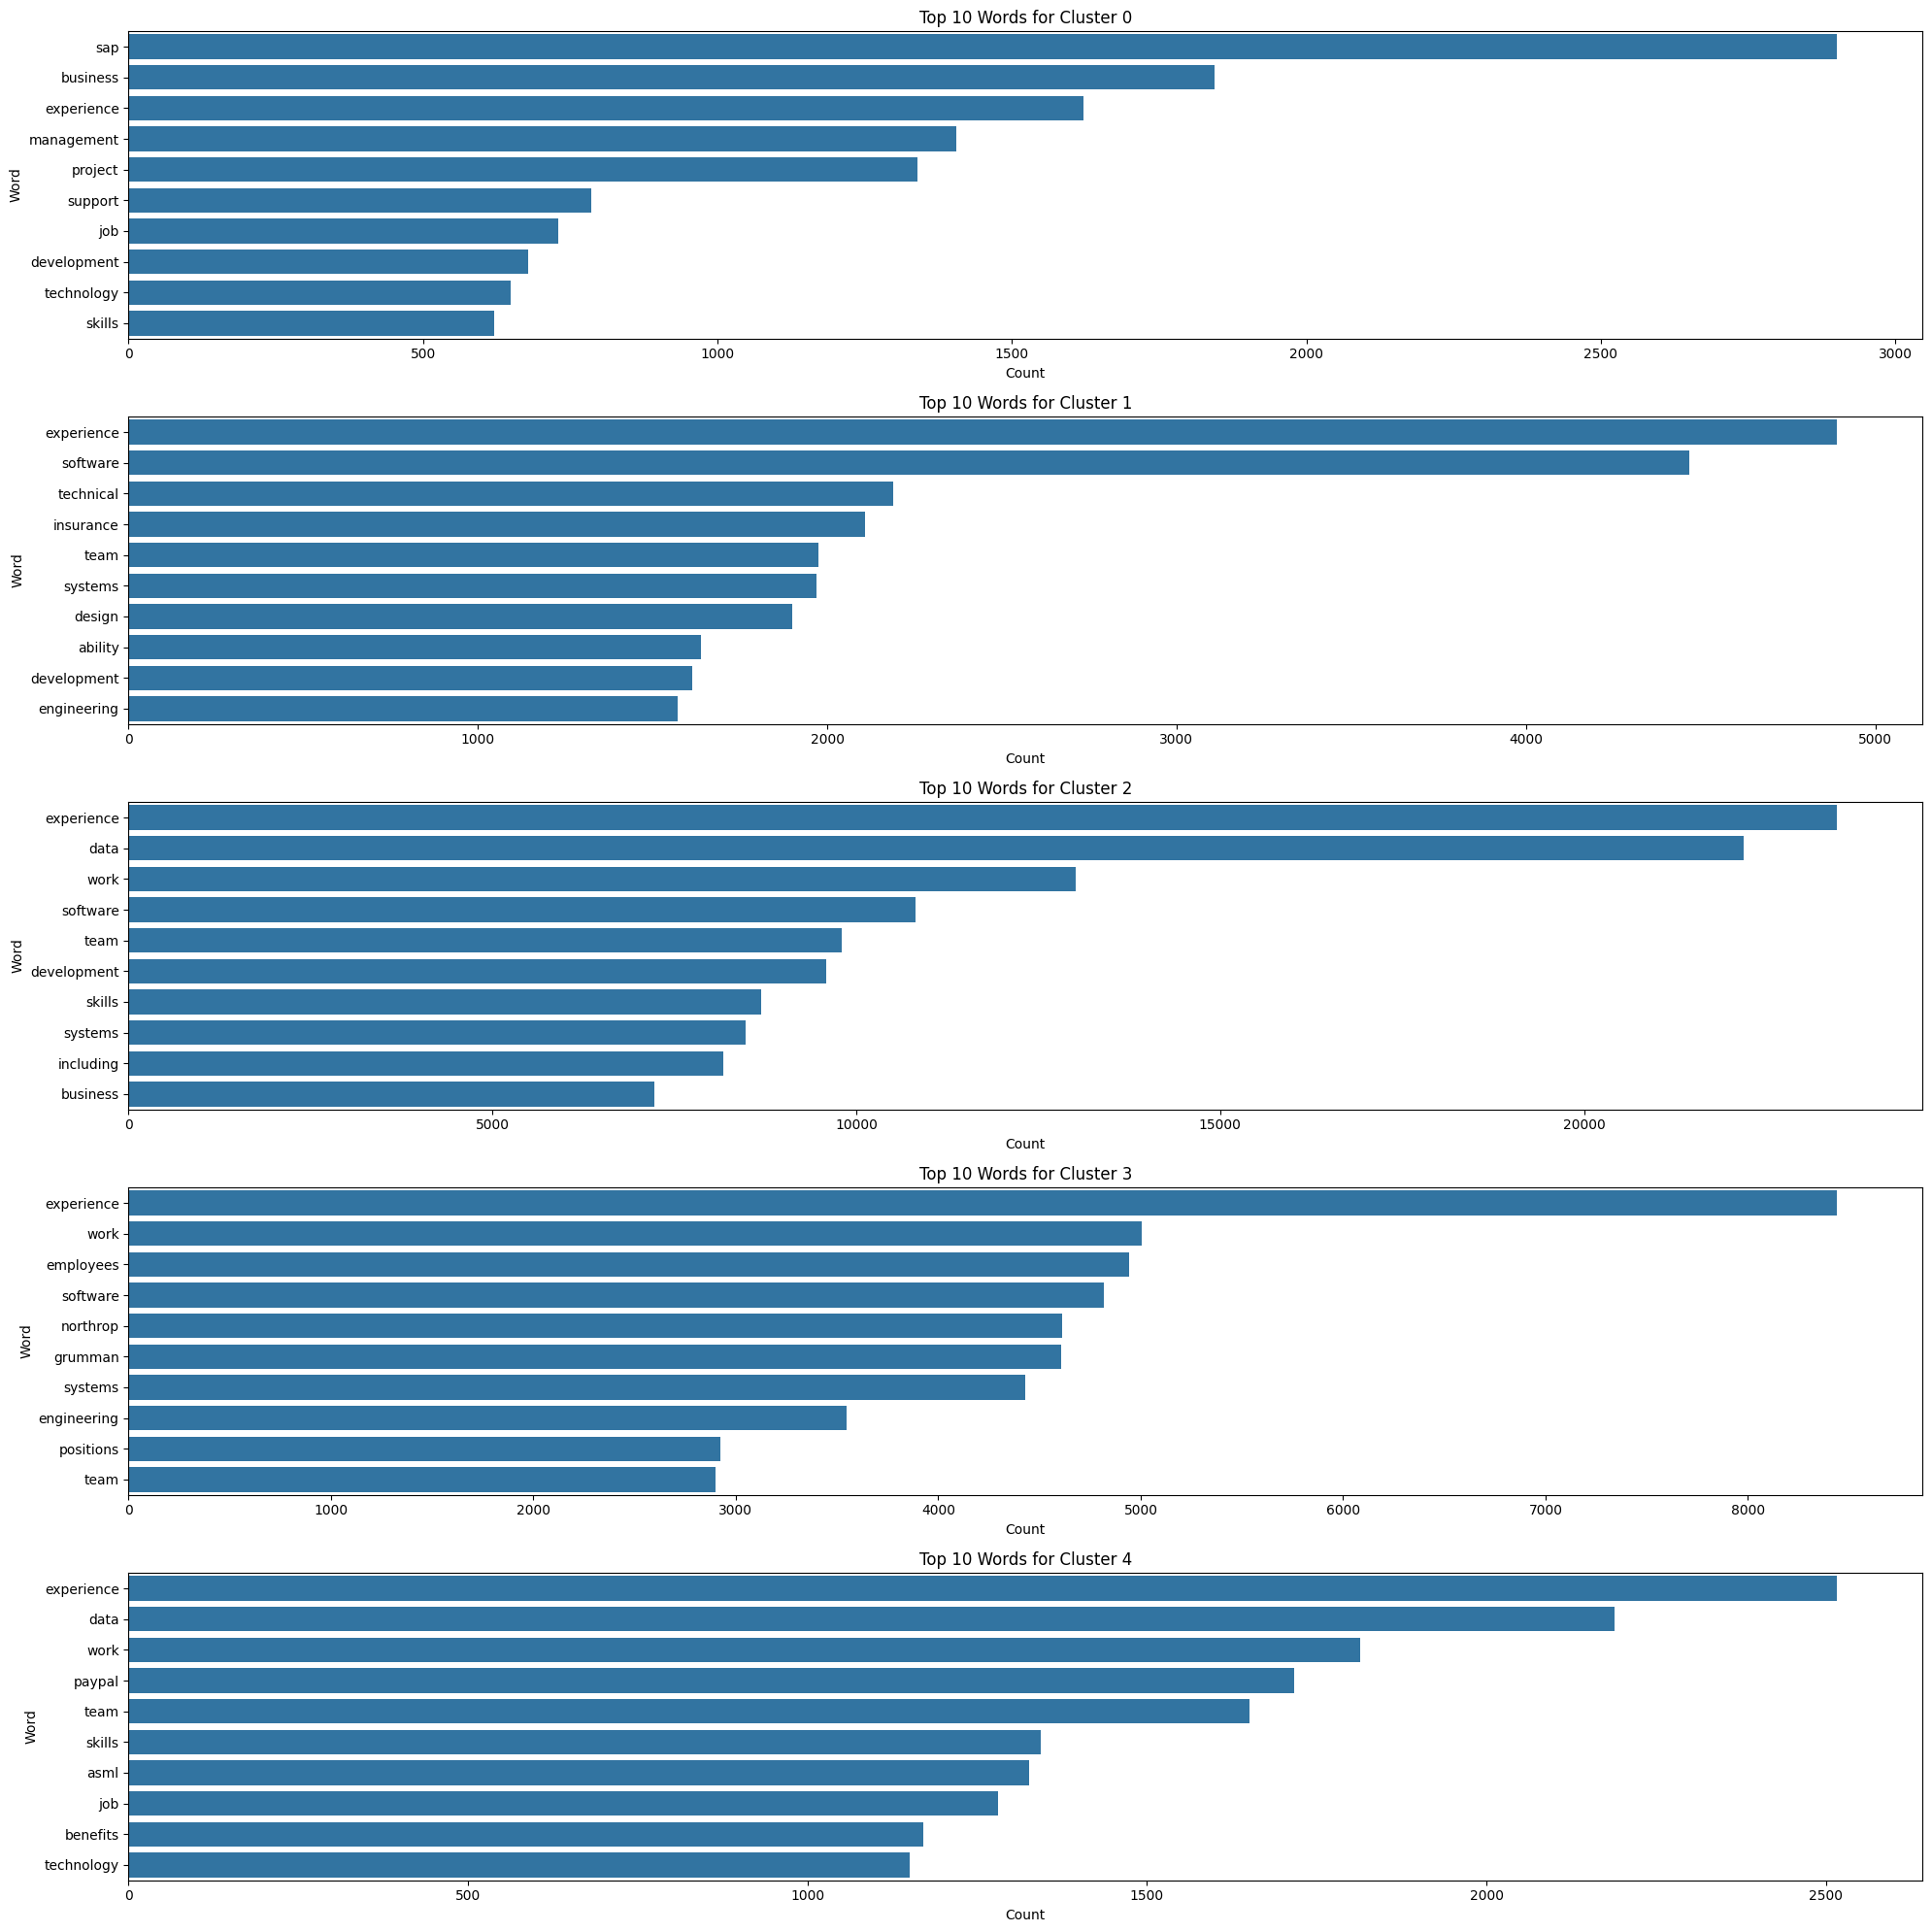

In [18]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string

# Function to get top N words, excluding stop words and punctuation
def get_top_words(text, n=10):
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split into words
    words = text.split()
    
    # Remove stop words
    words = [word for word in words if word not in ENGLISH_STOP_WORDS and len(word) > 1]
    
    # Count words
    word_counts = Counter(words)
    return dict(word_counts.most_common(n))

# Create a plot for each cluster
plt.figure(figsize=(20, 4*optimal_k))

for cluster in range(optimal_k):
    cluster_jobs = data[cluster_labels == cluster]
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    
    # Get top 10 words
    top_words = get_top_words(cluster_text)
    
    # Create a DataFrame for seaborn
    word_df = pd.DataFrame(list(top_words.items()), columns=['Word', 'Count'])
    
    # Create subplot
    plt.subplot(optimal_k, 1, cluster+1)
    
    # Create bar plot using seaborn
    sns.barplot(x='Count', y='Word', data=word_df, orient='h')
    
    plt.title(f'Top 10 Words for Cluster {cluster}')
    plt.xlabel('Count')
    plt.ylabel('Word')

plt.tight_layout()
plt.show()


In [19]:
# Print cluster analysis
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_jobs = data[cluster_labels == cluster]
    print(f"Number of jobs: {len(cluster_jobs)}")
    print("Top job titles:")
    print(cluster_jobs['Job_Title'].value_counts().head())
    print("\nMost common words:")
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    top_words = get_top_words(cluster_text, n=10)
    for word, count in top_words.items():
        print(f"{word}: {count}")



Cluster 0:
Number of jobs: 233
Top job titles:
Job_Title
Project Coordinator & Data Analyst    48
Expert IT SAP Functional Analyst      47
SAP ME/MII Developer                  35
Expert Business System Specialist     25
Analyst (Music Royalties) (4002)      25
Name: count, dtype: int64

Most common words:
sap: 2901
business: 1845
experience: 1622
management: 1406
project: 1340
support: 786
job: 729
development: 678
technology: 649
skills: 621

Cluster 1:
Number of jobs: 663
Top job titles:
Job_Title
Software Engineer                   249
Sr. Software Developer              168
Landing Page Developer/Designer     108
Software Engineer Manager C++ C#    105
Software Engineer Lead               33
Name: count, dtype: int64

Most common words:
experience: 4890
software: 4467
technical: 2190
insurance: 2109
team: 1974
systems: 1968
design: 1899
ability: 1638
development: 1614
engineering: 1572

Cluster 2:
Number of jobs: 4060
Top job titles:
Job_Title
Medicine - Artificial Intelligence F

## Fine Tuning
To effectively generate resume enhancement recommendations, we fine-tune our model to identify alignment gaps between the current resume content and job descriptions.

In [22]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the dataset
data = pd.read_csv('data/merged_file.csv')

# Fill missing values
data = data[['Job_Title', 'Job_Details']].fillna('')

# Vectorize job details with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(data['Job_Details']).toarray()

# Encode job titles as numeric labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Job_Title'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define an enhanced neural network model
model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Multi-class classification for job titles
])

# Compile the model with improved optimizer settings
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the early stopping callback
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Save the model for future use
model.save('resume_enhanced_generator_model.keras')

# Function to predict job title based on job description
def predict_job_title(job_description, model, vectorizer, label_encoder):
    # Vectorize the job description input
    job_description_vector = vectorizer.transform([job_description]).toarray()

    # Predict the job title
    prediction = model.predict(job_description_vector)
    predicted_job_title = label_encoder.inverse_transform([prediction.argmax()])

    return predicted_job_title[0]

# Example usage for testing
job_description_input = data['Job_Details'].iloc[0]  # Example job description
predicted_job_title = predict_job_title(job_description_input, model, vectorizer, label_encoder)

print(f"Predicted Job Title for provided description:\n{predicted_job_title}\n")

# Print several example predictions
print("Examples of predicted job titles for the first few job descriptions in the dataset:\n")
for i in range(5):
    job_desc = data['Job_Details'].iloc[i]
    predicted_title = predict_job_title(job_desc, model, vectorizer, label_encoder)
    print(f"Job Description: {job_desc}\nPredicted Job Title: {predicted_title}\n")


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.1132 - loss: 5.5219 - val_accuracy: 0.4740 - val_loss: 3.1140
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4925 - loss: 2.9355 - val_accuracy: 0.6520 - val_loss: 2.0418
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6316 - loss: 2.0451 - val_accuracy: 0.7504 - val_loss: 1.5070
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7301 - loss: 1.4835 - val_accuracy: 0.8073 - val_loss: 1.2262
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7845 - loss: 1.1469 - val_accuracy: 0.8325 - val_loss: 1.0775
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8141 - loss: 0.8886 - val_accuracy: 0.8585 - val_loss: 0.9946
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8441 - loss: 0.7175 - val_accuracy: 0.8789 - val_loss: 0.9666
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8756 - loss: 0.5874 - val_accuracy

## Predicting Salaries

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import re
from scipy.sparse import hstack

# Load the dataset
data = pd.read_csv('data/merged_file.csv')

# Define a function to process the 'Estimated_Salary' column
def extract_salary(salary_str):
    # Use regex to find the numbers in the salary range
    match = re.findall(r'\$\d+\.?\d*K', salary_str)
    if match:
        # Convert salary strings to numbers (e.g., "$99.3K" -> 99300)
        salaries = [float(s.replace('$', '').replace('K', '')) * 1000 for s in match]
        # Return the midpoint of the salary range
        return sum(salaries) / len(salaries)
    return None

# Apply the salary extraction function and drop rows where salary couldn't be extracted
data['Job_Salary'] = data['Estimated_Salary'].apply(lambda x: extract_salary(str(x)))
data = data.dropna(subset=['Job_Salary'])  # Drop rows with missing salary

# Fill missing values for 'Company_Name', 'Job_Location', and 'Job_Details' if needed
data['Company_Name'] = data['Company_Name'].fillna('Unknown')
data['Job_Location'] = data['Job_Location'].fillna('Unknown')
data['Job_Details'] = data['Job_Details'].fillna('')

# Use 'Job_Title', 'Company_Name', 'Job_Location', and 'Job_Details' as input features, and 'Job_Salary' as the target variable
X_title_raw = data['Job_Title']
X_company_raw = data['Company_Name']
X_location_raw = data['Job_Location']
X_details_raw = data['Job_Details']
y = data['Job_Salary'].values

# Vectorize 'Job_Title' and 'Job_Details' with TF-IDF
vectorizer_title = TfidfVectorizer(max_features=2000, stop_words='english')
X_title = vectorizer_title.fit_transform(X_title_raw)

vectorizer_details = TfidfVectorizer(max_features=3000, stop_words='english')
X_details = vectorizer_details.fit_transform(X_details_raw)

# One-hot encode 'Company_Name' and 'Job_Location'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_company_location = encoder.fit_transform(data[['Company_Name', 'Job_Location']])

# Combine all features into a single matrix
X = hstack([X_title, X_details, X_company_location])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the target variable for better performance
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Define the neural network model for regression
model = tf.keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model for regression with an adjusted optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='mean_squared_error', 
              metrics=['mae'])  # Mean Absolute Error as a metric for regression

# Use only the ReduceLROnPlateau callback for learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model with only the learning rate scheduler
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[reduce_lr])

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predicted and actual values to their original scale
y_pred_rescaled = scaler.inverse_transform(y_pred).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate the R-squared value
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

2024-10-17 12:04:43.610011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.9406 - mae: 0.7814 - val_loss: 0.8070 - val_mae: 0.6941 - learning_rate: 5.0000e-04
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.6983 - mae: 0.6469 - val_loss: 0.7244 - val_mae: 0.6479 - learning_rate: 5.0000e-04
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.5821 - mae: 0.5789 - val_loss: 0.7224 - val_mae: 0.6498 - learning_rate: 5.0000e-04
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.5241 - mae: 0.5472 - val_loss: 0.7182 - val_mae: 0.6467 - learning_rate: 5.0000e-04
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.5667 - mae: 0.5645 - val_loss: 0.7193 - val_mae: 0.6411 - learning_rate: 5.0000e-04
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.5090 - mae: 0.5400 - val_loss: 0.7201 - val_mae: 0.6377 - learning_rate: 5.0000e-04
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.5558 - mae: 0.5514 - val_loss: 0.7175 - val_mae: 0.6265 - learning_ra

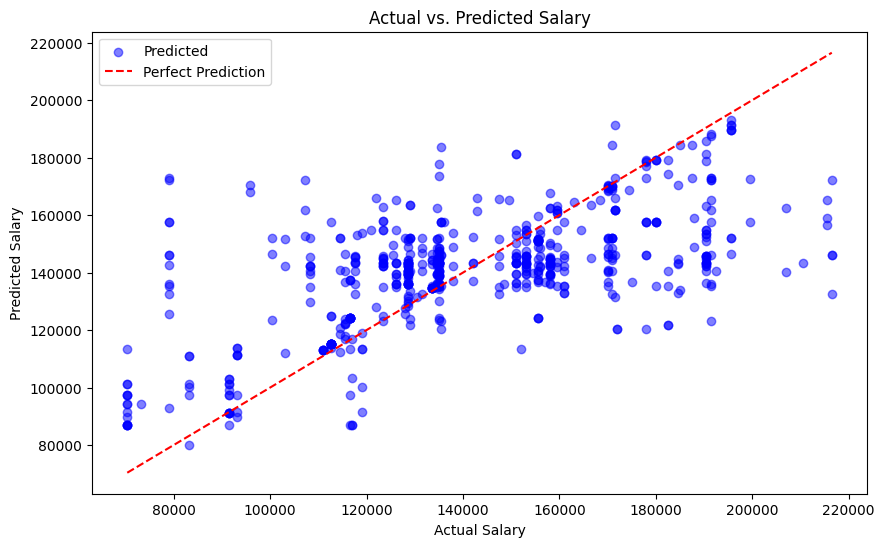

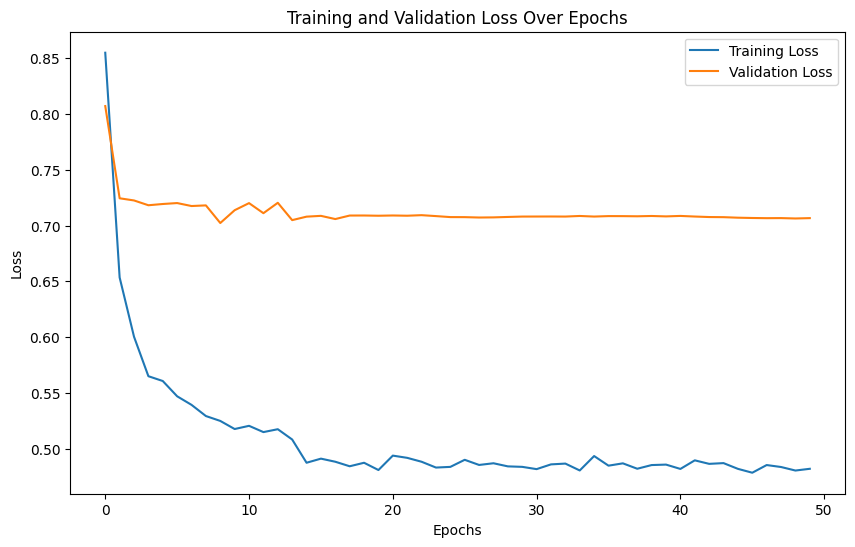

In [2]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5, color='b', label='Predicted')
plt.plot([y_test_rescaled.min(), y_test_rescaled.max()], [y_test_rescaled.min(), y_test_rescaled.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs. Predicted Salary')
plt.legend()
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()